<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Style Transfer

## Objective
To explore an alternative use of DNNs by implementing the style transfer algorithm ([Gatys et. al. 2016](https://arxiv.org/pdf/1508.06576.pdf)).
To understand the importance of a complex loss function.
To see how we can optimize not only over network parameters,
but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function, 
we will give you the code for this.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from pathlib import Path
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [ ]:
# Use this code to upload your own images

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512,512)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving Moraine Lake Canada.jpg to Moraine Lake Canada (2).jpg

Upload Style Image


Saving flat-landscape-yosemite.jpg to flat-landscape-yosemite (3).jpg
Content Path: <_io.BytesIO object at 0x7f56e85a6150>
Style Path: <_io.BytesIO object at 0x7f56e85a66d0>


In [ ]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()

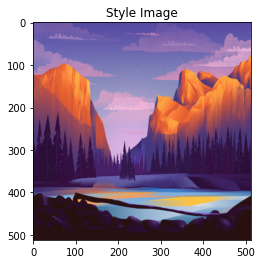

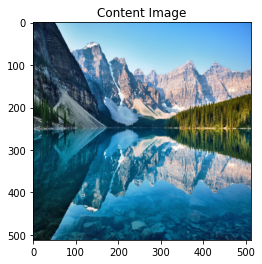

In [ ]:
# Display the images
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')

In [ ]:
device = 'cuda'

In [ ]:
# Functions for saving/loading model checkpoints
def save_model_checkpoint(model, optimizer, content_loss_funcs, style_loss_funcs, content_idxs, style_idxs, epoch, file_path):
    save_dict = {
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'content_idxs': content_idxs,
        'style_idxs': style_idxs,
        'num_content_loss_funcs': len(content_loss_funcs),
        'num_style_loss_funcs': len(style_loss_funcs),
    }

    for i, c in enumerate(content_loss_funcs):
        save_dict[f'content_loss_func_{i}'] = c.state_dict()
    
    for i, s in enumerate(style_loss_funcs):
        save_dict[f'style_loss_func_{i}'] = s.state_dict()

    torch.save(save_dict, file_path)

def load_model_from_checkpoint(path, model_class, optimizer_class, content_loss_func_class, style_loss_func_class):
    model = model_class(*args, **kwargs)
    optimizer =  optimizer_class(*args, **kwargs)

    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    epoch = checkpoint['epoch']
    style_idxs = checkpoint['style_idxs']
    content_idxs = checkpoint['content_idxs']

    num_content_funcs = checkpoint['num_content_loss_funcs']
    num_style_funcs = checkpoint['num_style_loss_funcs']
    content_loss_funcs = []
    style_loss_funcs = []

    for i in range(num_content_funcs):
        content_loss_func = content_loss_func_class(*args, **kwargs)
        content_loss_funcs.append(content_loss_func.load_state_dict(checkpoint[f'content_loss_func_{i}']))
    
    for i in range(num_style_funcs):
        style_loss_func = style_loss_func_class(*args, **kwargs)
        style_loss_funcs.append(style_loss_func.load_state_dict(checkpoint[f'style_loss_func_{i}']))


    return model, optimizer, content_loss_funcs, style_loss_funcs, content_idxs, style_idxs, epoch

___

### Part 1
Create a class to extract the layers needed for statistics

**TODO:**

**DONE:**
* Use the pretrained VGG in your model
* Gather statistics from the outputs of intermediate layers for the content image
* Gather statistics for the style image


In [ ]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
        
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(self.norm(x))  
    return self.intermediates

In [ ]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", 
             "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", 
             "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", 
             "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", 
             "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

# Choose the layers to use for style and content transfer
content_layers = [24]
style_layers = [0, 5, 10, 17, 24]
layer_idxs = content_layers + style_layers

In [ ]:
# style_weights_per_layer = torch.tensor([100, 10, 1, 0]).float()
# style_weight_per_layer = style_weights_per_layer / style_weights_per_layer.max()

In [ ]:
vgg_inter = VGGIntermediate(requested=layer_idxs).to(device).eval()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


In [ ]:
content_feats = vgg_inter(content_image).copy()
style_feats = vgg_inter(style_image).copy()

___

### Part 2
Create a classes for the style and content loss

**TODO:**

**DONE:**

* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the class
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the class


In [ ]:
def gram_matrix(input):
    b, m, h, w = input.size()
    feats = input.view(b * m, h * w)
    feat_dot = feats @ feats.t()
    return feat_dot #/ (b * m * h * w) # Normalize
  
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        return 0.5 * F.mse_loss(input, self.target)
    
class StyleLoss(nn.Module):
    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target).detach()
        self.weight = weight

    def forward(self, input):
        b, m, h, w = input.size()
        representation_size = 1 / (4 * m**2 * (h*w)**2)
        return representation_size * F.mse_loss(gram_matrix(input), self.target)




In [ ]:
# Instantiate a content loss module for each content layer 
#  with the content reference image outputs for that layer for comparison
content_loss_modules = []
for k, v in content_feats.items():
    if k in content_layers:
        content_loss_modules.append(ContentLoss(v))

# Instantiate a style loss module for each style layer 
#  with the style reference image outputs for that layer for comparison
style_weight = 1 / len(style_layers)
style_loss_modules = []
for k, v in style_feats.items():
    if k in style_layers:
        style_loss_modules.append(StyleLoss(v, style_weight))


___

### Part 3
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

**DONE:**
* Use an Adam optimizer (try learning rate of .1)
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!


In [ ]:
# Trainer class
class StyleTransfer():
    def __init__(self):
        self.input_img = None
        self.model = None
        self.optimizer = None

        self.content_layer_idxs = None
        self.style_layer_idxs = None
        self.content_alpha = None
        self.style_beta = None
        self.style_weight = None
        self.content_loss_funcs = None
        self.style_loss_funcs = None

        self.device = 'cuda'
        self.step_count = 1

        self.save_path = None

    def increment_step_count(self):
        self.step_count += 1

    def save_checkpoint(self):
        #print("Saving checkpoint...")
        save_model_checkpoint(self.model, self.optimizer, self.content_loss_funcs, self.style_loss_funcs, self.content_layer_idxs, self.style_layer_idxs, self.step_count, self.save_path)

    def init_from_checkpoint(self, file_path):
        model, optimizer, content_loss_funcs, style_loss_funcs, content_idxs, style_idxs, step = load_model_from_checkpoint(file_path, VGGIntermediate, optim.Adam, ContentLoss, StyleLoss)

        self.model = model
        self.optimizer = optimizer
        self.content_loss_funcs = content_loss_funcs
        self.style_loss_funcs = style_loss_funcs
        self.content_layer_idxs = content_idxs
        self.style_layer_idxs = style_idxs
        self.step_count = step
        self.save_path = file_path

    def run(self, num_steps):
        try:
            while self.step_count <= num_steps:
                # Set gradient to 0
                self.optimizer.zero_grad()
                # Get y_hat values
                vgg_output = self.model(self.input_img)               
                content_losses, style_losses = self.get_loss_values_(vgg_output)

                # Compare to y_truth values per layer
                style_loss = 0
                content_loss = 0                
                for i, c in enumerate(content_losses):
                    content_loss += self.content_loss_funcs[i](c)

                for i, s_loss in enumerate(style_losses):
                    style_loss += (self.style_weight * self.style_loss_funcs[i](s_loss))

                total_loss = (self.content_alpha * content_loss) + (self.style_beta * style_loss)
                # Need to call the backwards function manually
                total_loss.backward()

                if (self.step_count % 50 == 0):
                    print(f'Step {self.step_count} of {num_steps}')
                    print('Style Loss : {:f}, Content Loss: {:4f}, Total Loss: {:4f}'.format(
                        style_loss.item(), 
                        content_loss.item(),
                        total_loss.item()))

                self.optimizer.step()

                #self.save_checkpoint()
                self.increment_step_count()
                
        except KeyboardInterrupt:
            print("Process interrupted.")
            self.save_checkpoint()


        self.input_img.data.clamp_(0, 1)
        return self.input_img

    def get_loss_values_(self, input_feats):
        content_losses = []
        style_losses = []
        for k, v in input_feats.items():
            if k in self.content_layer_idxs:
                content_losses.append(v)
            if k in self.style_layer_idxs:
                style_losses.append(v)

        return content_losses, style_losses


Step 50 of 700
Style Loss : 0.000046, Content Loss: 1.380305, Total Loss: 6.014607
Step 100 of 700
Style Loss : 0.000033, Content Loss: 1.151539, Total Loss: 4.415393
Step 150 of 700
Style Loss : 0.000028, Content Loss: 1.196206, Total Loss: 3.970944
Step 200 of 700
Style Loss : 0.000019, Content Loss: 1.071882, Total Loss: 2.969800
Step 250 of 700
Style Loss : 0.000019, Content Loss: 1.339633, Total Loss: 3.288628
Step 300 of 700
Style Loss : 0.000015, Content Loss: 1.002707, Total Loss: 2.535943
Step 350 of 700
Style Loss : 0.000015, Content Loss: 1.008447, Total Loss: 2.468247
Step 400 of 700
Style Loss : 0.000019, Content Loss: 1.120952, Total Loss: 3.008552
Step 450 of 700
Style Loss : 0.000014, Content Loss: 1.052858, Total Loss: 2.500730
Step 500 of 700
Style Loss : 0.000012, Content Loss: 0.970139, Total Loss: 2.188664
Step 550 of 700
Style Loss : 0.000012, Content Loss: 0.917498, Total Loss: 2.072609
Step 600 of 700
Style Loss : 0.000011, Content Loss: 0.948928, Total Loss: 2.

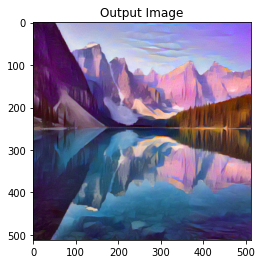

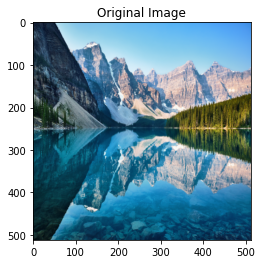

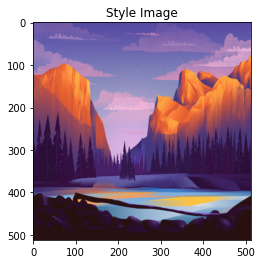

In [ ]:
# import copy
model_save_dir = Path('./models/')
model_file_ext = ".pt"

st_save_dir = model_save_dir.joinpath('style-transfer')
st_save_dir.mkdir(parents=True, exist_ok=True)
model_save_file = model_save_dir.joinpath('borderlands' + model_file_ext)

# Start with a copy of the content image
input_image = nn.Parameter(content_image.clone())

# Run the optimizer on the images to change the image
#  using the loss of the style and content layers
#  to backpropagate errors
lr = 0.01
optimizer = optim.Adam([input_image.requires_grad_()], lr=lr)

# Initialize StyleTransfer
style_transfer = StyleTransfer()
style_transfer.optimizer = optimizer
style_transfer.model = vgg_inter
style_transfer.save_path = model_save_file
style_transfer.content_layer_idxs = content_layers
style_transfer.style_layer_idxs = style_layers
style_transfer.content_loss_funcs = content_loss_modules
style_transfer.style_loss_funcs= style_loss_modules
style_transfer.input_img = input_image
style_transfer.content_alpha = 1
style_transfer.style_beta = 100000
style_transfer.style_weight = style_weight

# Run "training" loop
num_steps = 700
output = style_transfer.run(num_steps)

# Show the image
plt.figure()
display(output, title='Output Image')

plt.figure()
display(content_image, title='Original Image')

plt.figure()
display(style_image, title='Style Image')

### Part 4

**TODO:**

**DONE:**

- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

#### Equation 1:
This equation describes the content loss function. 

* Variables:
    * *p* - original content image
    * *x* - generated image
    * *l* - layer of a feature representation
    * *F<sup>l</sup><sub>ij</sub>* - feature representation of the original image stored as a series of layers with *i* filters of size *j*
    * *P<sup>l</sup><sub>ij</sub>* - feature representation of the generated image stored as a series of layers with *i* filters of size *j*

Given an image, *p* and the generated image, *x*. For any layer *l* of their respective feature representations (*F<sup>l</sup>*, *P<sup>l</sup>*); take the sum of the squared-errors between *F<sup>l</sup><sub>ij</sub>* and  *P<sup>l</sup><sub>ij</sub>* and divide by 2.

#### Equation 3:
This equation describes the Gram matrix which is used in style loss function. 

* Variables:
    * *F<sup>l</sup><sub>ik</sub>* - vectorized feature representation, *i*, at a given layer *l* of a given image
    * *F<sup>l</sup><sub>jk</sub>* - vectorized feature representation, *j*, at a given layer *l* of a given image

The Gram matrix is the inner producy between *F<sup>l</sup><sub>ik</sub>* and *F<sup>l</sup><sub>jk</sub>* which are summed over *k*, where *k* is the number of filters at layer *l*.

### Equation 4:
This equation describes the style loss, for a given layer, of a style representations for both the original style image and the generated image. The result from this equation is represented as *E<sub>l</sub>*.

* Variables: 
    * *N<sub>l</sub>* - number of distinct filters/feature maps at layer *l*
    * *M<sub>l</sub>* - height * width of a feature map at layer *l*
    * *G<sup>l</sup><sub>ij</sub>* - The Gram matrix for the original image's style feature representation at layer *l*
    * *A<sup>l</sup><sub>ij</sub>* - The Gram matrix for the generated image's style feature representation at layer *l*

Given the Gram matrices (*G<sup>l</sup><sub>ij</sub>*, *A<sup>l</sup><sub>ij</sub>*) of both images at a given layer *l* take the sum of the squared-errors between *G<sup>l</sup><sub>ij</sub>* and *A<sup>l</sup><sub>ij</sub>* and divide by, 4 * *N<sub>l</sub><sup>2</sup>* * *M<sub>l</sub><sup>2</sup>*.

### Equation 5:
This equation describes the total style loss when comparing the original style image and the generated image.

* Variables
    * *a* - original style image
    * *x* - generated image
    * *w<sub>l</sub>* - weighting factor for a given layer *l*
    * *E<sub>l</sub>* - style loss for a given layer *l*

Given an image, *a* and the generated image, *x*. For every layer *l* sum the product of *w<sub>l</sub>* * *E<sub>l</sub>*.